In [236]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import math

from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

In [237]:
df_train = pd.read_csv('./train.csv')
df_test = pd.read_csv('./test.csv')
gen_submission = pd.read_csv('./gender_submission.csv')

df_test['Survived'] = gen_submission['Survived']

df_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


Посмотрим на первичную информацию о данных.

In [238]:
df_train.shape

(891, 12)

In [239]:
df_train.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

Значит, в табличке всего 891 запись и 12 столбцов. Один из них -- целевая переменная Survived. Она равна 1, если человек выжил, и 0, если нет.

Теперь посмотрим, есть ли пропуски в данных.

In [240]:
df_train.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [241]:
for col in df_train.columns:
    percent_of_missing_values = df_train[col].isnull().sum() / len(df_train[col]) * 100
    print(f'{col}: {round(percent_of_missing_values, 3)} %')

PassengerId: 0.0 %
Survived: 0.0 %
Pclass: 0.0 %
Name: 0.0 %
Sex: 0.0 %
Age: 19.865 %
SibSp: 0.0 %
Parch: 0.0 %
Ticket: 0.0 %
Fare: 0.0 %
Cabin: 77.104 %
Embarked: 0.224 %


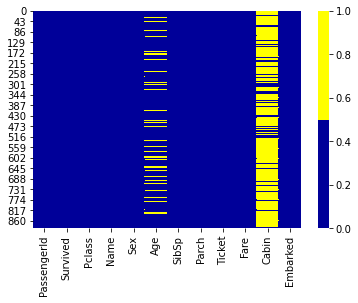

In [242]:
colors = ['#000099','#ffff00']
sns.heatmap(df_train.isnull(), cmap = sns.color_palette(colors))
plt.show()

In [243]:
# В столбце Cabin 77% данных пропущено, поэтому просто убираем его из рассмотрения
df_train = df_train.drop(columns=['Cabin'])
df_test = df_test.drop(columns=['Cabin'])

In [244]:
# Теперь, основываясь на стандартном отклонении возраста и его среднем значении, заполним пробелы в столбце Age
for df in [df_train, df_test]:
    mean = df['Age'].mean()
    std = df['Age'].std()
    number_of_nulls = df['Age'].isnull().sum()
    random_ages = np.random.randint(mean - std, mean + std, size=number_of_nulls)

    # Заменяем пропущенные значения сгенерированными числами
    new_ages = df['Age'].copy()
    new_ages[np.isnan(new_ages)] = random_ages
    df['Age'] = new_ages

In [245]:
# В Embarked всего лишь 2 пропуска, поэтому просто заполним их самым часто встречающимся значением
print(df_train['Embarked'].value_counts())

for df in [df_train, df_test]:
    df['Embarked'] = df['Embarked'].fillna('S')

S    644
C    168
Q     77
Name: Embarked, dtype: int64


In [246]:
print(df_train.isna().sum(), end='\n\n')
print(df_test.isna().sum())

PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Embarked       0
dtype: int64

PassengerId    0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           1
Embarked       0
Survived       0
dtype: int64


In [247]:
# Уберём из df_test единственную запись, где пропущено значение Fare
df_test = df_test[df_test['Fare'].notnull()]

В таблице не осталось пропущенных значений. Займемся визуализацией и отбором признаков.

In [248]:
# Признак Name, скорее всего, не будет полезен при предсказании
# Могли бы быть полезны обращения типа Mrs., Mr., Miss., но у нас уже есть признаки с полом и возрастом
df['Name'].values[:20]

array(['Kelly, Mr. James', 'Wilkes, Mrs. James (Ellen Needs)',
       'Myles, Mr. Thomas Francis', 'Wirz, Mr. Albert',
       'Hirvonen, Mrs. Alexander (Helga E Lindqvist)',
       'Svensson, Mr. Johan Cervin', 'Connolly, Miss. Kate',
       'Caldwell, Mr. Albert Francis',
       'Abrahim, Mrs. Joseph (Sophie Halaut Easu)',
       'Davies, Mr. John Samuel', 'Ilieff, Mr. Ylio',
       'Jones, Mr. Charles Cresson',
       'Snyder, Mrs. John Pillsbury (Nelle Stevenson)',
       'Howard, Mr. Benjamin',
       'Chaffee, Mrs. Herbert Fuller (Carrie Constance Toogood)',
       'del Carlo, Mrs. Sebastiano (Argenia Genovesi)',
       'Keane, Mr. Daniel', 'Assaf, Mr. Gerios',
       'Ilmakangas, Miss. Ida Livija',
       'Assaf Khalil, Mrs. Mariana (Miriam")"'], dtype=object)

In [249]:
# Дропнем имена и ID пассажиров
df_train = df_train.drop(columns=['Name', 'PassengerId'])
df_test = df_test.drop(columns=['Name', 'PassengerId'])

In [250]:
len(df['Ticket'].unique()) / len(df['Ticket'])

0.868421052631579

In [251]:
# Так как 76% значений в столбце Ticket уникальны, то он вряд ли даёт существенную информацию о целевой переменной
df_train = df_train.drop(columns=['Ticket'])
df_test = df_test.drop(columns=['Ticket'])

In [252]:
df_train

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,male,22.0,1,0,7.2500,S
1,1,1,female,38.0,1,0,71.2833,C
2,1,3,female,26.0,0,0,7.9250,S
3,1,1,female,35.0,1,0,53.1000,S
4,0,3,male,35.0,0,0,8.0500,S
...,...,...,...,...,...,...,...,...
886,0,2,male,27.0,0,0,13.0000,S
887,1,1,female,19.0,0,0,30.0000,S
888,0,3,female,30.0,1,2,23.4500,S
889,1,1,male,26.0,0,0,30.0000,C


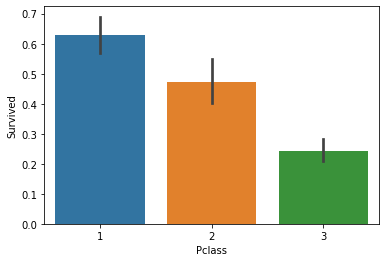

In [253]:
# Чем меньше номер класса, тем выше была вероятность выжить
sns.barplot(data=df_train, x='Pclass', y='Survived')
plt.show()

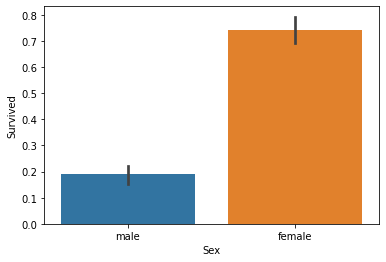

In [254]:
# У женщин, в среднем, вероятность выжить была заметно больше, чем у мужчин
sns.barplot(data=df_train, x='Sex', y='Survived')
plt.show()

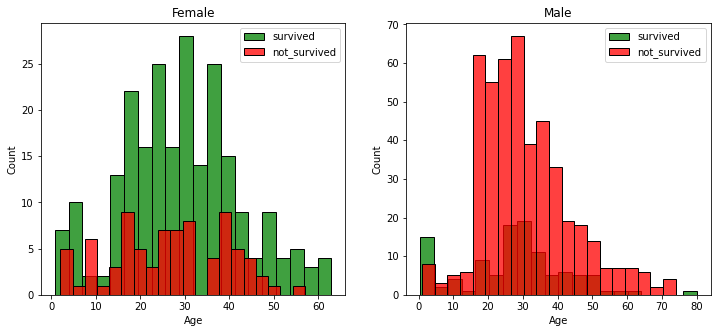

In [255]:
# Распределение для выживших и не выживших мужчин и женщин в зависимости от возраста
women_df = df_train[df_train['Sex']=='female']
men_df = df_train[df_train['Sex']=='male']

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

ax = sns.histplot(women_df[women_df['Survived']==1]['Age'], bins=20, label = 'survived', ax = axes[0], kde =False, color='green')
ax = sns.histplot(women_df[women_df['Survived']==0]['Age'], bins=20, label = 'not_survived', ax = axes[0], kde =False, color='red')
ax.legend()
ax.set_title('Female')

ax = sns.histplot(men_df[men_df['Survived']==1]['Age'], bins=20, label = 'survived', ax = axes[1], kde = False, color='green')
ax = sns.histplot(men_df[men_df['Survived']==0]['Age'], bins=20, label = 'not_survived', ax = axes[1], kde = False, color='red')
ax.legend()
ax.set_title('Male')
plt.show()

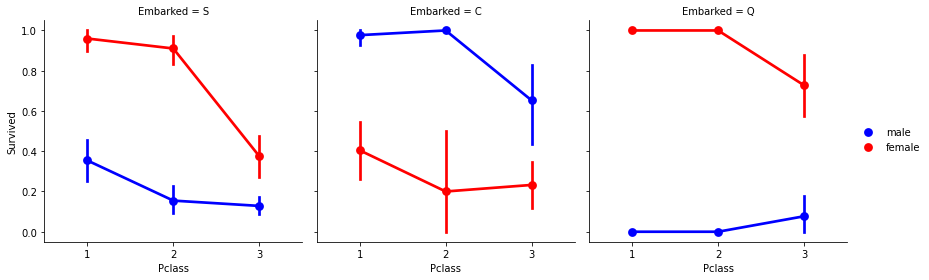

In [256]:
# Женщины, которые сели в порту S и Q выживали чаще, но чаще погибали, если садились в порту C.
# Мужчины имели больший шанс выжить, если сели в порту C, но чаще погибали, если садились в порту S и Q.

grid = sns.FacetGrid(df_train, col='Embarked', height=4, aspect=1)
grid.map(sns.pointplot, 'Pclass', 'Survived', 'Sex', palette=['blue', 'red'], order=None, hue_order=None )
grid.add_legend()
plt.show()

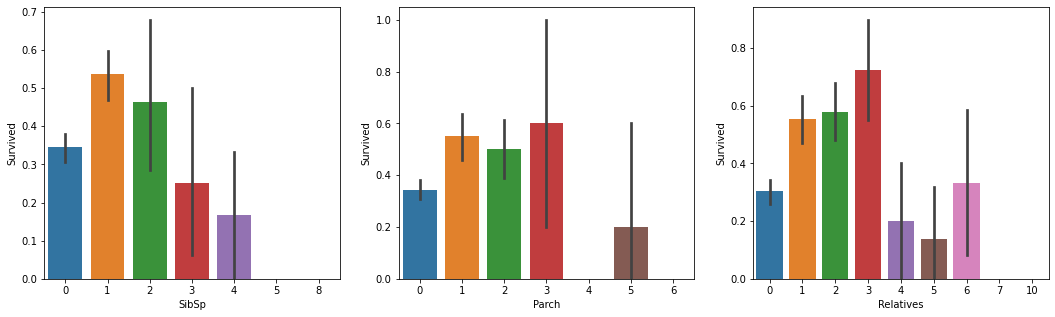

In [257]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

ax = sns.barplot(data=df_train, x='SibSp', y='Survived', ax=axes[0])
ax = sns.barplot(data=df_train, x='Parch', y='Survived', ax=axes[1])

df_train['Relatives'] = df_train['Parch'] + df_train['SibSp']
ax = sns.barplot(data=df_train, x='Relatives', y='Survived', ax=axes[2])
plt.show()

# Мы видим, что, в среднем, люди с 1-3 родственниками на борту выживают чаще. Заменим Parch и SibSp на Relatives для уменьшения количества признаков
df_test['Relatives'] = df_test['Parch'] + df_test['SibSp']
df_train = df_train.drop(columns=['SibSp', 'Parch'])
df_test = df_test.drop(columns=['SibSp', 'Parch'])

In [258]:
# Преобразуем признаки Sex и Embarked
genders = {'male': 0, 'female': 1}
ports = {"S": 0, "C": 1, "Q": 2}

for df in [df_train, df_test]:
    df['Sex'] = df['Sex'].map(genders)
    df['Embarked'] = df['Embarked'].map(ports)

In [259]:
# Формируем тренировочные и тестовые данные
X_train = df_train.drop(columns=['Survived'])
Y_train = df_train['Survived']

X_test = df_test.drop(columns=['Survived'])
Y_test = df_test['Survived']

df_test.head()

,Pclass,Sex,Age,Fare,Embarked,Survived,Relatives
0,3,0,34.5,7.8292,2,0,0
1,3,1,47.0,7.0000,0,1,1
2,2,0,62.0,9.6875,2,0,0
3,3,0,27.0,8.6625,0,0,0
4,3,1,22.0,12.2875,0,1,2


# Построение моделей
## 1. KNN с весами

In [260]:
class WeightedKNNClassifier:
    def __init__(self, K=3):
        self.K = K
    
    def fit(self, X_train, Y_train):
        self.X_train = X_train.to_numpy()
        self.Y_train = Y_train.to_numpy()

    def predict(self, X_test):
        X_test = X_test.to_numpy()

        # Нормализуем данные в каждом столбце
        self.X_train = np.apply_along_axis(lambda x: (x-x.mean())/ x.std(), 0, self.X_train)
        X_test = np.apply_along_axis(lambda x: (x-x.mean())/ x.std(), 0, X_test)

        Y_pred = []
        
        for p in X_test:        
            distances = list()
            # Считаем расстояния от данной точки до всех остальных
            for row_idx, row in enumerate(self.X_train):
                distance = 0
                for feature_idx in range(len(p)):
                    distance += (p[feature_idx] - row[feature_idx])**2

                # Добавляем в список пару расстояние-класс
                distances.append([math.sqrt(distance), Y_train[row_idx]])

            # Находим К ближайших точек
            k_closest_points = sorted(distances, key=lambda x: x[0])[:self.K]

            # Находим числа, обратные к каждому расстоянию
            inverse_distances = list()
            for dist in k_closest_points:
                inverse_distances.append(1/dist[0])
            
            # Находим сумму этих обратных чисел
            sum_of_inverses = sum(inverse_distances)
            
            # Находим вес для каждой точки + соответствующий ей класс
            weights = [[inverse/sum_of_inverses, k_closest_points[idx][1]] for idx, inverse in enumerate(inverse_distances)]

            # Считаем вероятности для каждого класса
            probabilities = {c : 0 for c in Y_train.unique()}
            for elem in weights:
                probabilities[elem[1]] += elem[0]
            
            # Возвращаем класс с максимальной вероятностью
            Y_pred.append(max(probabilities, key=probabilities.get))

        return np.array(Y_pred)

    def accuracy_score(self, Y_test, Y_pred):
	    return sum(np.array(Y_pred) == np.array(Y_test)) / len(Y_test)


In [261]:
'''
for i in range(2, 15):
    my_knn = WeightedKNNClassifier(K=i)
    my_knn.fit(X_train, Y_train)
    Y_pred = my_knn.predict(X_test)
    print(f"Accuracy for weighted KNN with K = {i} : {my_knn.accuracy_score(Y_test, Y_pred)}")
'''
# Из данного теста мы выяснили, что оптимальный K = 7

my_knn = WeightedKNNClassifier(K=7)
my_knn.fit(X_train, Y_train)
Y_pred = my_knn.predict(X_test)
print(f"Accuracy for weighted KNN with K = 7 : {my_knn.accuracy_score(Y_test, Y_pred)}")

Accuracy for weighted KNN with K = 7 : 0.8800959232613909


In [262]:
scores = []
for i in range(2, 100):
    knn = KNeighborsClassifier(n_neighbors = i)
    knn.fit(X_train, Y_train)
    Y_pred = knn.predict(X_test)
    scores.append((Y_test == Y_pred).sum() / len(Y_test))

print(f'Best accuracy for sklearn\'s KNN: {max(scores)}')

Best accuracy for sklearn's KNN: 0.6714628297362111


In [263]:
# Same with normalized data

X_train_normalized = X_train.apply(lambda x: (x-x.mean())/ x.std(), axis=0)
X_test_normalized = X_test.apply(lambda x: (x-x.mean())/ x.std(), axis=0)

scores = []
for i in range(2, 100):
    knn = KNeighborsClassifier(n_neighbors = i)
    knn.fit(X_train_normalized, Y_train)
    Y_pred = knn.predict(X_test_normalized)
    scores.append((Y_test == Y_pred).sum() / len(Y_test))

print(f'Best accuracy for sklearn\'s KNN with normalized data: {max(scores)}')

Best accuracy for sklearn's KNN with normalized data: 0.9760191846522782


In [264]:
class NaiveBayesClassifier:
    def __init__(self):
        pass

    def get_probabilities(self, class_idx: int, x: np.array) -> np.array:
        # Считаем вероятность как значение функции плотности нормального распределения в точке x=(p_1,..,p_n)  
    
        # Массив матожиданий и дисперсий для каждого признака при данном классе
        mean = self.mean_cond_class[class_idx]
        var = self.var_cond_class[class_idx]

        # Считаем вероятность для каждого признака, используя плотность вероятности нормального распределения
        exponent = np.exp((-1/2) * ((x-mean)**2) / (2 * var))
        probabilities = exponent / np.sqrt(2 * np.pi * var)
        return probabilities

    # Найдем P(class|p_1,..,p_n)
    def get_posterior(self, x: np.array) -> int:
        posteriors = []
        for class_idx in range(self.num_of_classes):
            prior = np.log(self.prior[class_idx])
            # Условная вероятность получить такие значения признаков для этого класса
            conditional = np.sum(np.log(self.get_probabilities(class_idx, x)))
            posterior = prior + conditional
            posteriors.append(posterior)
        # Возвращаем класс, для которого такая вероятность максимальна
        return self.classes[np.argmax(posteriors)]

    def fit(self, X_train, Y_train):
        self.classes = np.unique(Y_test)
        self.num_of_classes = len(self.classes)
        
        # Посчитаем выборочные средние и дисперсии для каждого признака в зависимости от класса
        self.mean_cond_class = X_train.groupby(Y_train).apply(np.mean).to_numpy()
        self.var_cond_class = X_train.groupby(Y_train).apply(np.var).to_numpy()

        # Считаем для каждого класса, сколько наблюдений принадлежит этому классу
        self.prior = X_train.groupby(Y_train).apply(lambda col: len(col))
        # Находим оценку вероятности того, что случайное наблюдение принадлежит этому классу
        # путём деления результатов на общее количество наблюдений
        self.prior = np.array(self.prior / len(Y_train))
        
    def predict(self, X_test):
        Y_pred = [self.get_posterior(f) for f in X_test.to_numpy()]
        return Y_pred
    
    def accuracy_score(self, Y_test, Y_pred):
	    return sum(Y_pred == Y_test) / len(Y_test)

In [265]:
nbc = NaiveBayesClassifier()
nbc.fit(X_train, Y_train)
Y_pred = nbc.predict(X_test)
print(f'Accuracy of custom Naive Bayes: {nbc.accuracy_score(Y_test, Y_pred)}')

Accuracy of custom Naive Bayes: 0.8033573141486811


In [266]:
gaussian = GaussianNB() 
gaussian.fit(X_train, Y_train) 
Y_pred = gaussian.predict(X_test)  
print(f'Accuracy of sklearn Naive Bayes: {gaussian.score(X_train, Y_train)}')

Accuracy of sklearn Naive Bayes: 0.797979797979798
